In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pwd

'/content'

In [ ]:
import pandas as pd
import numpy as np 
import os
import itertools
import keras


from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer

from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.models import Sequential 
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense  
from keras import applications 
#from keras.application.vgg16 import preprocess_input 
from keras.utils.np_utils import to_categorical  

import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

import imutils
import math  
import datetime
import time
from tqdm import tqdm
import cv2
print("Library Set Up Success")

Library Set Up Success


In [ ]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
           # print("path"+path)  
            for file in os.listdir(dir_path +'/'+ path):
              #  print(file)           
                if not file.startswith('.'):
                    img = cv2.imread(dir_path +'/'+ path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
sample_img=cv2.imread('/content/drive/MyDrive/EEG_Project/train/train/non_ictal1/10_0.jpg')

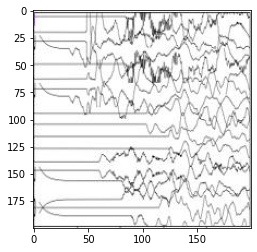

In [ ]:
plt.imshow(sample_img)

In [ ]:
sample_img.shape

(200, 200, 3)

In [ ]:
#Default dimensions we found online
IMG_SIZE=(32,32)
   
# loading up our datasets
train_data_dir = '/content/drive/MyDrive/EEG_Project/train/train'  
validation_data_dir = '/content/drive/MyDrive/EEG_Project/train/validation'  
test_data_dir = '/content/drive/MyDrive/EEG_Project/train/test'
X_train, y_train, labels = load_data(train_data_dir, IMG_SIZE)
X_test, y_test, _ = load_data(test_data_dir, IMG_SIZE)
X_val, y_val, _ = load_data(validation_data_dir, IMG_SIZE) 
# number of epochs to train top model  
epochs = 50
#this has been changed after multiple model run  
# batch size used by flow_from_directory and predict_generator  
batch_size = 32  
# print("Train Data\n")
# print(X_train)
print("Loading up our image datasets succes")

In [ ]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='Ictal',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Non Ictal',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [ ]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 5
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Data: {}'.format(labels_dict[index]))
        plt.show()

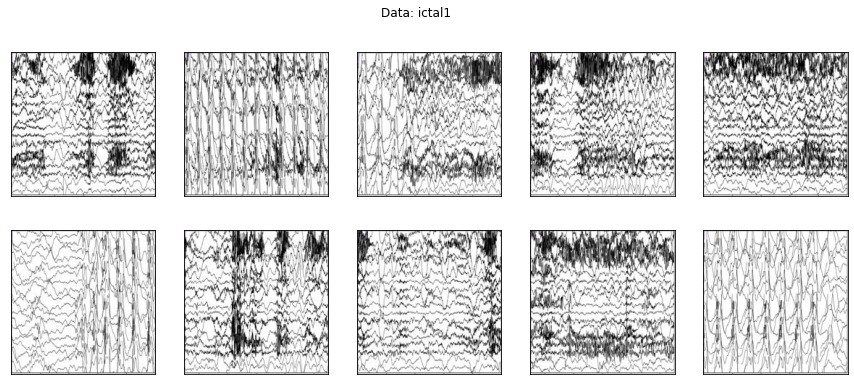

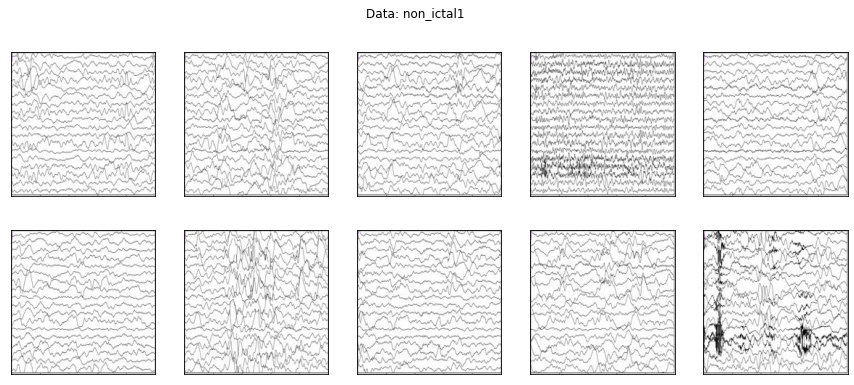

In [ ]:
plot_samples(X_train, y_train, labels, 10)

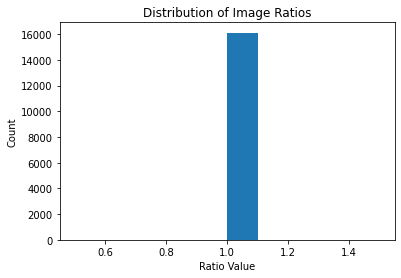

In [ ]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
        
plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

In [ ]:
img_width, img_height = 128, 128

#setting up the directories
train_data_dir = '/content/drive/MyDrive/EEG_Project/train/train'
validation_data_dir = '/content/drive/MyDrive/EEG_Project/train/validation'
input_shape = (img_width, img_height, 3)
batch_size = 32  

In [ ]:
# this is the augmentation configuration we will use for training
# augumentation generates more training images by rescaling, shearing, etc
train_datagen = ImageDataGenerator(
    rescale=1./ 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [ ]:
#this generates batches of augment data for training
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 15516 images belonging to 2 classes.


In [ ]:
# this is the augmentation configuration we will use for validating
val_datagen = ImageDataGenerator(rescale=1./255)

#this generates batches of augment data for validating
validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 500 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = input_shape, # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
## Loading VGG16 model

base_model.trainable = False ## Not trainable weights



In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
%cd "/content/drive/MyDrive/EEG_Project"

/content/drive/MyDrive/EEG_Project


In [ ]:
%pwd

'/content/drive/MyDrive/EEG_Project'

In [ ]:
from tensorflow.keras import layers, models
from keras.layers import  Dropout, BatchNormalization


flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(512, activation='relu')
normal=BatchNormalization()
dense_layer_2 = Dropout(0.5)
prediction_layer = layers.Dense(1, activation='sigmoid')

In [ ]:
model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 18,910,017
Trainable params: 4,195,329
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

callbacks= [ModelCheckpoint('model_VGG.h5', save_weights_only=False, save_best_only=True, verbose=1)]

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)


# es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)



In [ ]:
history=model.fit(train_generator, epochs=5, validation_data=validation_generator, batch_size=32, callbacks=[callbacks])

Epoch 1/5
485/485 [==============================] - ETA: 0s - loss: 0.4162 - accuracy: 0.8338
Epoch 1: val_loss improved from inf to 0.46730, saving model to model_VGG.h5
485/485 [==============================] - 4073s 8s/step - loss: 0.4162 - accuracy: 0.8338 - val_loss: 0.4673 - val_accuracy: 0.7480
Epoch 2/5
485/485 [==============================] - ETA: 0s - loss: 0.3174 - accuracy: 0.8728
Epoch 2: val_loss improved from 0.46730 to 0.34050, saving model to model_VGG.h5
485/485 [==============================] - 108s 222ms/step - loss: 0.3174 - accuracy: 0.8728 - val_loss: 0.3405 - val_accuracy: 0.8560
Epoch 3/5
485/485 [==============================] - ETA: 0s - loss: 0.2972 - accuracy: 0.8835
Epoch 3: val_loss did not improve from 0.34050
485/485 [==============================] - 104s 215ms/step - loss: 0.2972 - accuracy: 0.8835 - val_loss: 0.4584 - val_accuracy: 0.7720
Epoch 4/5
485/485 [==============================] - ETA: 0s - loss: 0.2823 - accuracy: 0.8893
Epoch 4: val

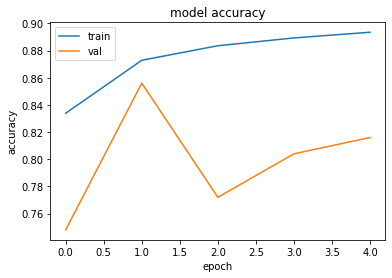

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

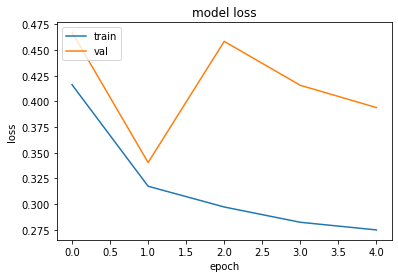

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()